In [1]:
from transformers import AutoTokenizer, BertForMaskedLM
import torch

2024-08-08 15:47:36.255111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:47:36.270751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:47:36.270775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 15:47:36.281097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 15:47:38.556129: W tensorflow/compiler/tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

/nethome/kgeorge/miniconda3/envs/workspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")

In [7]:
inputs.input_ids

tensor([[ 101, 1996, 3007, 1997, 2605, 2003,  103, 1012,  102]])

In [8]:
with torch.no_grad():
    logits = model(**inputs).logits

In [9]:
logits.shape

torch.Size([1, 9, 30522])

In [10]:
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

In [11]:
mask_token_index, tokenizer.mask_token_id

(tensor([6]), 103)

In [12]:
logits[0, mask_token_index].argmax(axis=-1)

tensor([3000])

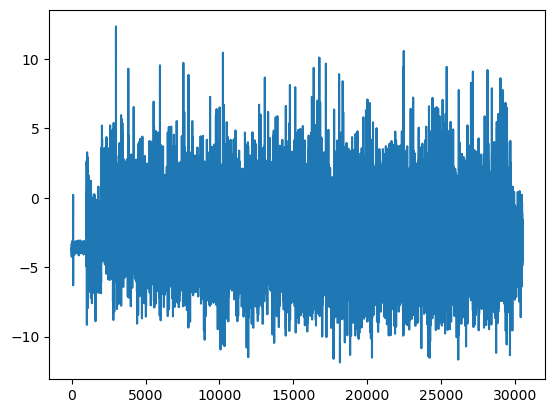

In [13]:
plt.plot(logits[0, mask_token_index].numpy()[0])

In [14]:
logits[0, mask_token_index]

tensor([[-3.7861, -3.8572, -3.5644,  ..., -2.5593, -3.1093, -4.3820]])

In [15]:
prob = torch.nn.functional.softmax(logits, dim=-1)[0, mask_token_index]

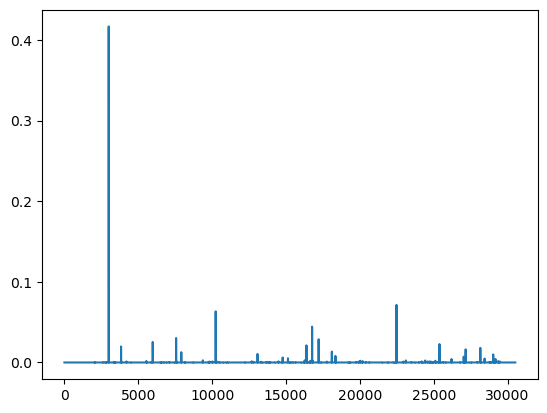

In [16]:
plt.plot(prob.numpy()[0])

In [17]:
samples = torch.multinomial(prob, 10000, replacement=True)

In [18]:
unique_samples, freq = samples[0].unique(return_counts=True)
freq = freq/freq.sum()

In [19]:
subset = 20
sorted_sub_sample = unique_samples[freq.argsort(descending=True)][:20]
sorted_sub_freq = freq[freq.argsort(descending=True)][:20]

In [20]:
import numpy as np

In [21]:
for i, sample in enumerate(sorted_sub_sample):
    print(f'freq = {round(sorted_sub_freq[i].item(),3)} \t LLM prob =  {round(prob[0,sample].item(),3)} \t token = {tokenizer.decode(sample)}')

freq = 0.427 	 LLM prob =  0.417 	 token = paris
freq = 0.072 	 LLM prob =  0.071 	 token = lille
freq = 0.06 	 LLM prob =  0.063 	 token = lyon
freq = 0.046 	 LLM prob =  0.044 	 token = marseille
freq = 0.03 	 LLM prob =  0.029 	 token = toulouse
freq = 0.029 	 LLM prob =  0.03 	 token = tours
freq = 0.024 	 LLM prob =  0.025 	 token = orleans
freq = 0.021 	 LLM prob =  0.023 	 token = brest
freq = 0.021 	 LLM prob =  0.023 	 token = nantes
freq = 0.02 	 LLM prob =  0.021 	 token = bordeaux
freq = 0.02 	 LLM prob =  0.02 	 token = nice
freq = 0.016 	 LLM prob =  0.016 	 token = toulon
freq = 0.016 	 LLM prob =  0.018 	 token = montpellier
freq = 0.013 	 LLM prob =  0.013 	 token = strasbourg
freq = 0.011 	 LLM prob =  0.011 	 token = var
freq = 0.01 	 LLM prob =  0.01 	 token = pau
freq = 0.01 	 LLM prob =  0.013 	 token = nancy
freq = 0.009 	 LLM prob =  0.008 	 token = versailles
freq = 0.007 	 LLM prob =  0.007 	 token = rouen
freq = 0.007 	 LLM prob =  0.006 	 token = cannes


#### Drift Experiment

In [118]:
import copy

In [195]:
inputs = tokenizer("Mountains are challenging to climb. High altitudes make breathing harder. Only experienced hikers attempt them.", return_tensors="pt")

In [196]:
mask_token_id = tokenizer.encode(tokenizer.special_tokens_map['mask_token'])[1]
print(f'mask token id: {mask_token_id}')

mask token id: 103


In [197]:
inputs

{'input_ids': tensor([[  101,  4020,  2024, 10368,  2000,  7105,  1012,  2152, 21973,  2191,
          5505,  6211,  1012,  2069,  5281, 21857,  2869,  3535,  2068,  1012,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [212]:
tokenizer.decode(inputs.input_ids[0][7:12])

'high altitudes make breathing harder'

In [168]:
from tqdm import tqdm

In [169]:
_ = model.to('cuda')

In [213]:
counts_100 = []
trials = 3
rounds = 10000
storage = []
for i in range(trials):
    current = copy.deepcopy(inputs)
    current.to('cuda')
    counts = []
    temp = []
    collection = set()
    for i in tqdm(range(rounds)):
        # print(f'Round {i+1} -----')
        # print('current: \t\t', tokenizer.decode(current.input_ids[0]))
        sample_pos = np.random.randint(7, 12)
        current.input_ids[0][sample_pos] = mask_token_id
        # print('Random masking: \t', tokenizer.decode(current.input_ids[0]))
        with torch.no_grad():
            logits = model(**current).logits

        prob = torch.nn.functional.softmax(logits, dim=-1)[0, sample_pos]
        sample = torch.multinomial(prob, 1, replacement=True)
        # print('LLM pred: \t\t', tokenizer.decode(sample))

        current.input_ids[0][sample_pos] = sample
        # print('LLM pred: \t\t', tokenizer.decode(current.input_ids[0]))
        # print('')
        collection.add(tokenizer.decode(current.input_ids[0]))
        counts.append(len(collection))
        temp.append(tokenizer.decode(current.input_ids[0]))

    counts_100.append(counts)
    storage.append(temp)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:08<00:00, 145.31it/s]


Text(0.5, 0, 'rounds')

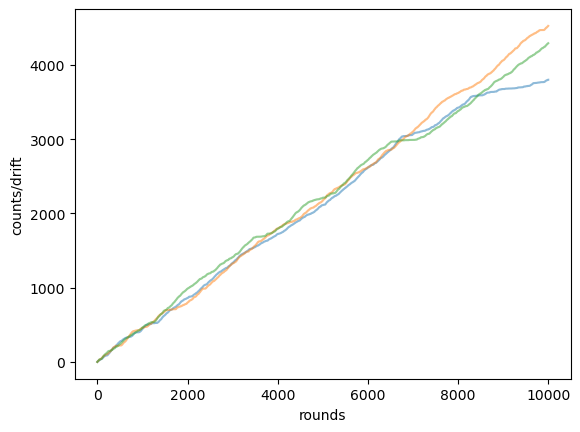

In [214]:
for x in counts_100:
    plt.plot(x, alpha=0.5)
plt.ylabel('counts/drift')
plt.xlabel('rounds')
# plt.xscale('log')

In [219]:
storage[0][-1000:]

['[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. only experienced hikers attempt them. [SEP]',
 '[CLS] mountains are challenging to climb. hikers cannot climb them. on

In [220]:
current = copy.deepcopy(inputs)
current.to('cuda')
counts = []
collection = set()
for i in range(1000):
    print(f'Round {i+1} -----')
    print('current: \t\t', tokenizer.decode(current.input_ids[0]))
    sample_pos = np.random.randint(7, 13)
    current.input_ids[0][sample_pos] = mask_token_id
    print('Random masking: \t', tokenizer.decode(current.input_ids[0]))
    with torch.no_grad():
        logits = model(**current).logits

    # prob = torch.nn.functional.softmax(logits, dim=-1)[0, sample_pos]
    # sample = torch.multinomial(prob, 1, replacement=True)
    sample = logits[0, sample_pos].argmax(axis=-1)
    # print('LLM pred: \t\t', tokenizer.decode(sample))

    current.input_ids[0][sample_pos] = sample
    print('LLM pred: \t\t', tokenizer.decode(current.input_ids[0]))
    print('')
    collection.add(tokenizer.decode(current.input_ids[0]))
    counts.append(len(collection))

Round 1 -----
current: 		 [CLS] mountains are challenging to climb. high altitudes make breathing harder. only experienced hikers attempt them. [SEP]
Random masking: 	 [CLS] mountains are challenging to climb. high altitudes make breathing [MASK]. only experienced hikers attempt them. [SEP]
LLM pred: 		 [CLS] mountains are challenging to climb. high altitudes make breathing difficult. only experienced hikers attempt them. [SEP]

Round 2 -----
current: 		 [CLS] mountains are challenging to climb. high altitudes make breathing difficult. only experienced hikers attempt them. [SEP]
Random masking: 	 [CLS] mountains are challenging to climb. [MASK] altitudes make breathing difficult. only experienced hikers attempt them. [SEP]
LLM pred: 		 [CLS] mountains are challenging to climb. high altitudes make breathing difficult. only experienced hikers attempt them. [SEP]

Round 3 -----
current: 		 [CLS] mountains are challenging to climb. high altitudes make breathing difficult. only experienced 

Text(0.5, 0, 'rounds')

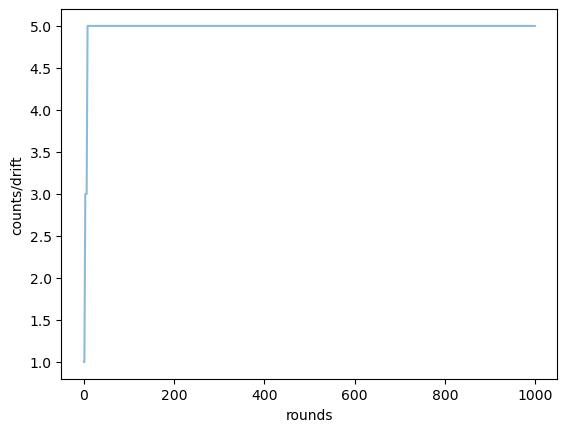

In [221]:
plt.plot(counts, alpha=0.5)
plt.ylabel('counts/drift')
plt.xlabel('rounds')
# plt.xscale('log')